## Librairies

In [11]:
from gymnasium import Env
import gymnasium
import numpy as np
import os
from stable_baselines3.common import env_checker
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete
from cargame import Car, Track, Vector
import pygame
import sys
import matplotlib.pyplot as plt
from gymnasium.wrappers import FlattenObservation

## Load Environment

In [2]:
def plot_car(background, car_position_pixels, size) -> None:
    fig, ax = plt.subplots()
    ax.imshow(background, cmap='gray')
    ax.plot(car_position_pixels.x,car_position_pixels.y, 'yo', markersize = size)
    plt.title('Binary Road Mask')
    plt.axis('off')  
    plt.show()

In [14]:
from time import time
from imageprocessing import image

class CarEnvironment(Env):
    MAX_EPOCH_TIME = 3 * 60

    def __init__(self,
                 ):
        # (speed, angle)
        self.action_space = Box(low=np.array([0.0, -1.0]), high=np.array([1.0, 1.0]), shape = (2,), dtype = np.float32)

        print("Loading pixels from image")
        pixels = image.transform_image('imageprocessing/image_test/test3redgreen.png')
        print(pixels.shape)
        plt.imshow(pixels, cmap='gray') 

        print("Creating track")
        track = Track(pixels)
        self.timestep = 0.1
        
        print("Creating Car")
        self.car = Car(12, 15, 0.5, 70, track, 0.05, Vector(0, 7), Vector(4.5, -5))

        print("Making observation space")
        cm_per_pixel = self.car.body_length / track.car_dimensions.y
        self.observation_space = Dict({
            'GridR' : Box(low = 0, high = 255, shape = (pixels.shape[1], pixels.shape[0]), dtype=np.uint8),
            'GridG' : Box(low = 0, high = 255, shape = (pixels.shape[1], pixels.shape[0]), dtype=np.uint8),
            'GridB' : Box(low = 0, high = 255, shape = (pixels.shape[1], pixels.shape[0]), dtype=np.uint8),
            'CarPositionX' : Box(low = 0, high = pixels.shape[1] * cm_per_pixel, shape=(1,1)),
            'CarPositionY' : Box(low = 0, high = pixels.shape[0] * cm_per_pixel, shape=(1,1)),
            'CarSpeed' : Box(low = 0, high = 1, shape = (1,1)),
            'CarAngle' : Box(low = 0, high = 1, shape = (1,1)),
            'TireAngle' : Box(low = -1, high = 1, shape = (1,1))
        })

        grid_size = self.observation_space['GridR'].shape[0] * self.observation_space['GridR'].shape[1] * 3 
        one_dimension_size = 5
        
        print("Making flat observation space")
        self.observation_space = Box(
            low = np.concatenate([
                self.observation_space['GridR'].low.flatten(),
                self.observation_space['GridG'].low.flatten(),
                self.observation_space['GridB'].low.flatten(),
                self.observation_space['CarPositionX'].low.flatten(), 
                self.observation_space['CarPositionY'].low.flatten(),
                self.observation_space['CarSpeed'].low.flatten(),
                self.observation_space['CarAngle'].low.flatten(), 
                self.observation_space['TireAngle'].low.flatten() 
            ]),
                
            high = np.concatenate([
                self.observation_space['GridR'].high.flatten(), 
                self.observation_space['GridG'].high.flatten(), 
                self.observation_space['GridB'].high.flatten(), 
                self.observation_space['CarPositionX'].high.flatten(),
                self.observation_space['CarPositionY'].high.flatten(),
                self.observation_space['CarSpeed'].high.flatten(), 
                self.observation_space['CarAngle'].high.flatten(), 
                self.observation_space['TireAngle'].high.flatten()                            
            ]),
            shape = (grid_size + one_dimension_size,)
        )

        self.start_time = time()
    
    def step(self, action):
        print("Reward:", self.car.reward)
        # Apply Action 
        angle = action[1]
        speed = action[0]

        # Action
        self.car.set_front_tire_angle(angle)
        self.car.set_speed(speed)
        self.car.update()
        
        print(self.car.angle)
        print(self.car.tire_angle)
        plot_car(self.car.track.pixels, self.car.get_pixel_position(), self.car.track.car_dimensions.x)
        
        # Terminated
        truncated = (time() - self.start_time) > CarEnvironment.MAX_EPOCH_TIME
        return self.car.get_state(), self.car.reward, self.car.check_if_done() or self.car.check_if_terminated(), truncated, {}
    
    def reset(self, seed):
        self.car.reset()
        self.start_time = time()
        plot_car(self.car.track.pixels, self.car.get_pixel_position(), self.car.track.car_dimensions.x)
        return (self.car.get_state(), {})
    
    def render(self):
        screen = pygame.display.set_mode((4000,3000))
    
        while True:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()

    def close(self) -> None:
        pass

## Train RL Model

Loading pixels from image
(96, 96, 3)
Creating track
Getting Start Pixel List
Got Start Pixel List
Creating Car
Making observation space
Making flat observation space


/Users/oli.dmrs/.pyenv/versions/3.11.9/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/oli.dmrs/.pyenv/versions/3.11.9/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


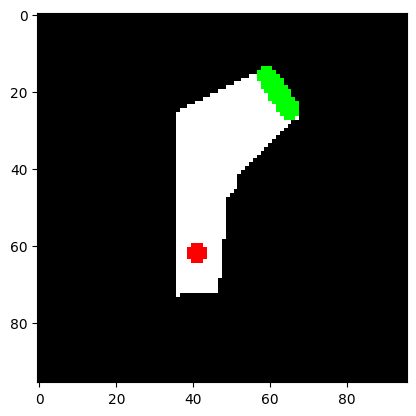

In [15]:
env = CarEnvironment()
# env = DummyVecEnv([lambda : env])

In [16]:
env_checker.check_env(env, warn=True, skip_render_check=True)

TypeError: The reset() method must accept a `seed` parameter

In [12]:
log_path = os.path.join('Training', 'Logs')
env = FlattenObservation(env)
# model = PPO('CnnPolicy', env, verbose = 1, tensorboard_log=log_path)
model = PPO('MlpPolicy', env, verbose = 2, tensorboard_log=log_path, n_steps=10)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/oli.dmrs/.pyenv/versions/3.11.9/lib/python3.11/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 10`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 10
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=10 and n_envs=1)
  warnings.warn(


In [13]:
env.reset()
model.learn(total_timesteps=10, progress_bar=True, )


TypeError: CarEnvironment.reset() got an unexpected keyword argument 'options'

## Save Model